# SINDy Anpassungen für das SIDARTHE System

In diesem Notebook versuchen wir Code aus dem Notebook "SIDARTHE und SINDy" so anzupassen, dass möglichst viele bekannte Informationen über das System benutzt werden.

### TODO: 
Aus dem Notebook "custom SINDy" (nicht online) müssen noch einige Resultate dokumentiert und dann eingefügt werden.

In [1]:
import pysindy as ps
# ignore wanings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sidarthe_functions_and_classes import *

### Idee:
Schreibe eine eigene feature_library um die Anzahl der Suchrichtungen zu verringern. Dadurch sollte es für den Optimierer leichter sein, auch mit etwas ungenauen Ableitungen oder ungenauem/keinem innitial_guess zu einem guten Ergebnis zu kommen.

### Achtung:
SINDy sucht immer eine Funktion, die möglichst wenig Funktionen aus der kombinierten feature_library benutzt. Zu wenig "falsche" Gleichungen kann also auch schlecht sein.

In [3]:
from pysindy.feature_library import CustomLibrary


class MyLibrary(CustomLibrary):
    """This class is only intended for a single case in which I manually create a function library with certain combinations for my application."""

    @staticmethod
    def _combinations(n_features, n_args, interaction_only):
        """Get the combinations of features to be passed to a library function."""

        def custom_combination(n_args):
            if n_args == 1:
                pool = tuple([1, 2, 3, 4, 5])
                i = 0
                while i in range(len(pool)):
                    yield tuple(pool[j] for j in range(i, i+1))
                    i += 1

            elif n_args == 2:
                pool = [(0, 1), (0, 2), (0, 3), (0, 4)]
                i = 0
                while i in range(len(pool)):
                    yield pool[i]
                    i += 1
            else:
                pass

        return custom_combination(n_args)

In [4]:
# initialguess new format

alpha = 0.175771057515159
beta = 0.00844384791042575
gamma = 0.1757710634027378
epsilon = 0.
theta = 0.1980571066560948
zeta = 0.07901877992285243
my_lambda = 0.05961066603689205
kappa = 0.056288791238505
mu = 0.013025936744049
sigma = 0.04406078628710332
tau = 0.019087122640751797


allgower_initial_guess_new = np.array([
    [0., 0., 0., 0., 0., -alpha, -beta, -gamma, -beta],
    [-(epsilon+zeta+my_lambda), 0., 0., 0., 0., alpha, beta, gamma, beta],
    [epsilon, -(zeta+my_lambda), 0., 0., 0., 0., 0., 0., 0.],
    [zeta, 0., -(theta+mu+kappa), 0., 0., 0., 0., 0., 0.],
    [0., zeta, theta, -(mu+kappa), 0., 0., 0., 0., 0.],
    [0., 0., mu, mu, -(sigma+tau), 0., 0., 0., 0.],
    [my_lambda, my_lambda, kappa, kappa, sigma, 0., 0., 0., 0.],
    [0., 0., 0., 0., tau, 0., 0., 0., 0.]])

S' = -0.031 I + 0.050 A + -0.329 SI + 0.010 SA + -0.015 SR
I' = -0.115 I + -0.041 A + 0.317 SI + 0.089 SA + 0.015 SR
D' = 0.000
A' = 0.084 I + -0.275 A + 0.005 SI + -0.053 SA
R' = 0.198 A + -0.069 R
T' = 0.013 A + 0.013 R + -0.063 T
H' = 0.063 I + 0.051 A + 0.056 R + 0.044 T + 0.005 SI + -0.046 SA
E' = 0.019 T


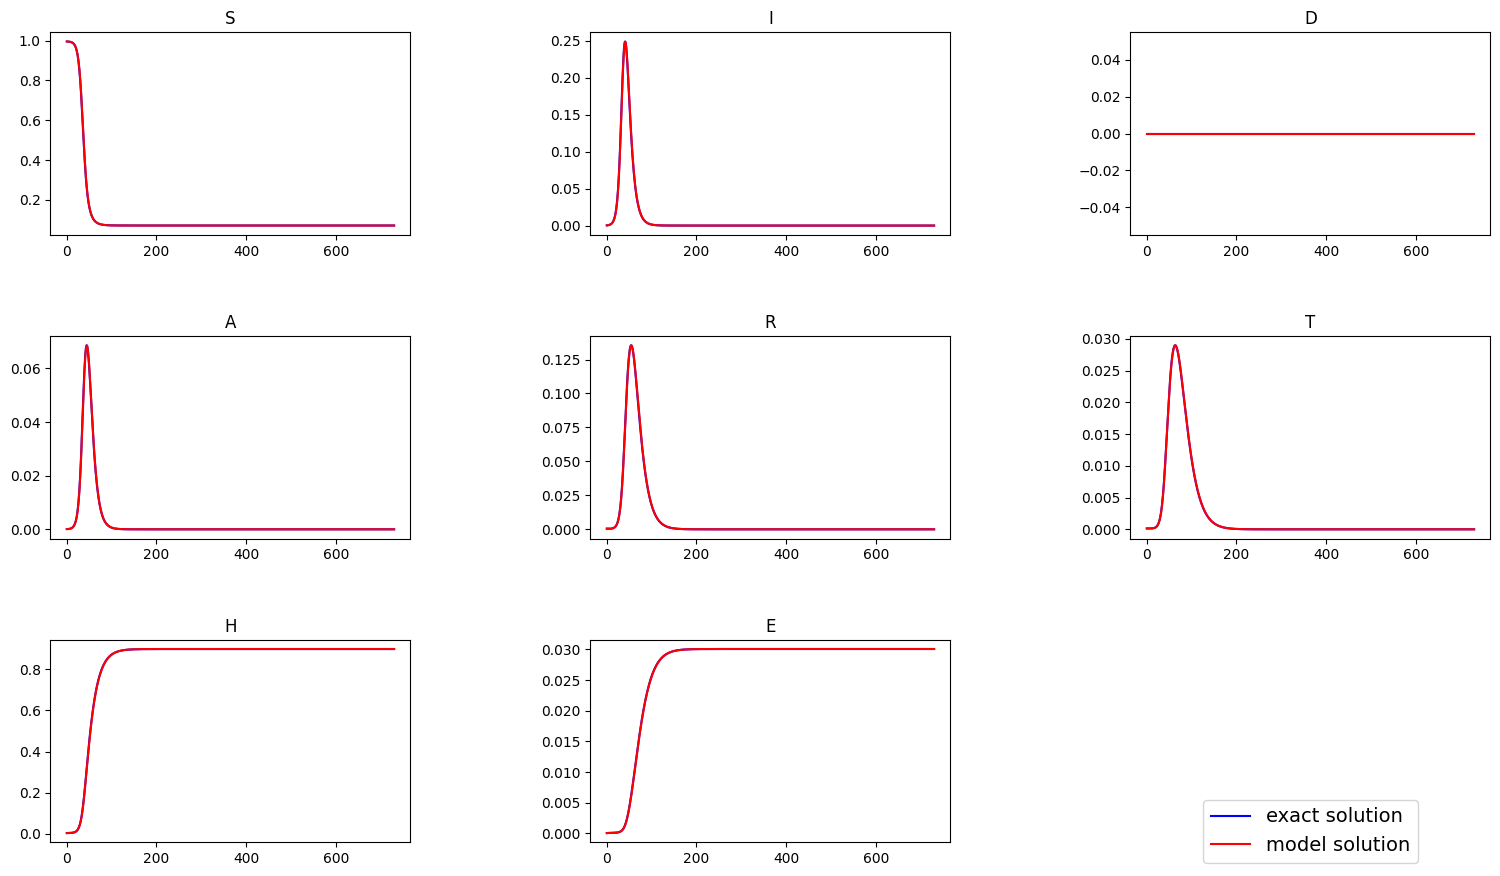

model score:  0.9999988239218427


In [5]:
parameters = Parameters8(alpha=0.3, gamma=0.3)
t, y = sidarthe_simulation8(parameters, t_end=730)

# Set feature library
feature_names = ["S", "I", "D", "A", "R", "T", "H", "E"]
functions = [lambda x: x, lambda x, y: x*y]
feature_library = MyLibrary(library_functions=functions, function_names=[
                            lambda x: x, lambda x, y: x+y])

# MODEL FIT
model = None #reset old model
model = ps.SINDy(
    differentiation_method=ps.FiniteDifference(),
    feature_library=feature_library,
    optimizer=ps.SR3(max_iter=10000, threshold=0.005, normalize=True,
                     initial_guess=None),
    feature_names=feature_names
)

model.fit(y, t=t, quiet=True)  # suppress warnings
model.print()

# SIMULATION
[s0, i0, d0, a0, r0, t0, h0, e0] = parameters.y0
sim = model.simulate([s0, i0, d0, a0, r0, t0, h0, e0], t=t)

# PLOT
plot_all_compare(t, y, sim, text="")

print("model score: ", model.score(y))

Es wurden nur die folgenden "features" verwendet:

In [6]:
print(f"Features ({model.n_output_features_}):", model.feature_library.get_feature_names(
    ["S", "I", "D", "A", "R", "T", "H", "E"]))

Features (9): ['I', 'D', 'A', 'R', 'T', 'SI', 'SD', 'SA', 'SR']


Für die letzte Berechnung wurden nur weniger Gleichungen zur Verfügung gestellt. Die Ableitungen wurden mittels finiter Differenzen berechnet! Vorher wurden ähnlich gute Parameter nur mithilfe von exakten Ableitungen geschätzt.

Ein mögliches Problem für die Interpretierbarkeit ist, dass die Parameter $\alpha$ und $\gamma$ recht weit auseinander liegen und vor allem $\gamma$ schlecht geschätzt (sogar mit falschem Vorzeichen) wurde. Das versuchen wir später eventuel mit constraints zu korrigieren.

Einige Hilfsfunktionen:

In [7]:
def exact_guess_function(p: Parameters8):
    alpha = p.alpha
    beta = p.beta
    gamma = p.gamma
    epsilon = p.epsilon
    theta = p.theta
    zeta = p.zeta
    my_lambda = p.my_lambda
    kappa = p.kappa
    mu = p.mu
    sigma = p.sigma
    tau = p.tau

    exact_initial_guess = np.array([
        [0., 0., 0., 0., 0., -alpha, -beta, -gamma, -beta],
        [-(epsilon+zeta+my_lambda), 0., 0., 0., 0., alpha, beta, gamma, beta],
        [epsilon, -(zeta+my_lambda), 0., 0., 0., 0., 0., 0., 0.],
        [zeta, 0., -(theta+mu+kappa), 0., 0., 0., 0., 0., 0.],
        [0., zeta, theta, -(mu+kappa), 0., 0., 0., 0., 0.],
        [0., 0., mu, mu, -(sigma+tau), 0., 0., 0., 0.],
        [my_lambda, my_lambda, kappa, kappa, sigma, 0., 0., 0., 0.],
        [0., 0., 0., 0., tau, 0., 0., 0., 0.]])

    return exact_initial_guess


def print_exact_model(exact_guess, model):
    for row in range(exact_guess.shape[0]):
        print(feature_names[row] + "' = '" + ps.utils.print_model(exact_guess[row],
                                                                  model.feature_library.get_feature_names(model.feature_names)))


def print_model_diff(exact_guess, model):
    """Print differences exact-model in System for readability"""
    print_exact_model(exact_guess-model.coefficients(), model)
    
def x_dot_exact_function(p: Parameters8, y):
    dF = sidarthe_system8(p)
    x_dot_exact = np.empty(y.shape)
    for index, y_row in enumerate(y):
        x_dot_exact[index] = dF(0, y_row) # the sidarte model is not time dependent
    return x_dot_exact

Allgemein ist SINDy nur dazu da eine gute Approximation für das System zu finden. Es ist nicht das einzige Ziel, einen möglichst guten "Fit" für gegebene Daten zu erhalten. Dadurch würde man nur overfitten und schlechte Ergebnisse erhalten. Da durch die sparse Optimierung nicht alle Parameter exakt getroffen werden, versuchen wir, die wichtigsten Parameter besser zu approximieren, indem wir hier $\alpha = \gamma$ vorgeben.

S' = -0.299 SI + -0.299 SA + -0.011 SR
I' = -0.125 I + -0.048 A + 0.288 SI + 0.288 SA + 0.053 SR
D' = 0.000
A' = 0.085 I + -0.277 A + 0.006 SI + -0.062 SA
R' = 0.198 A + -0.069 R
T' = 0.013 A + 0.013 R + -0.063 T
H' = 0.063 I + 0.051 A + 0.056 R + 0.044 T + 0.005 SI + -0.046 SA
E' = 0.019 T


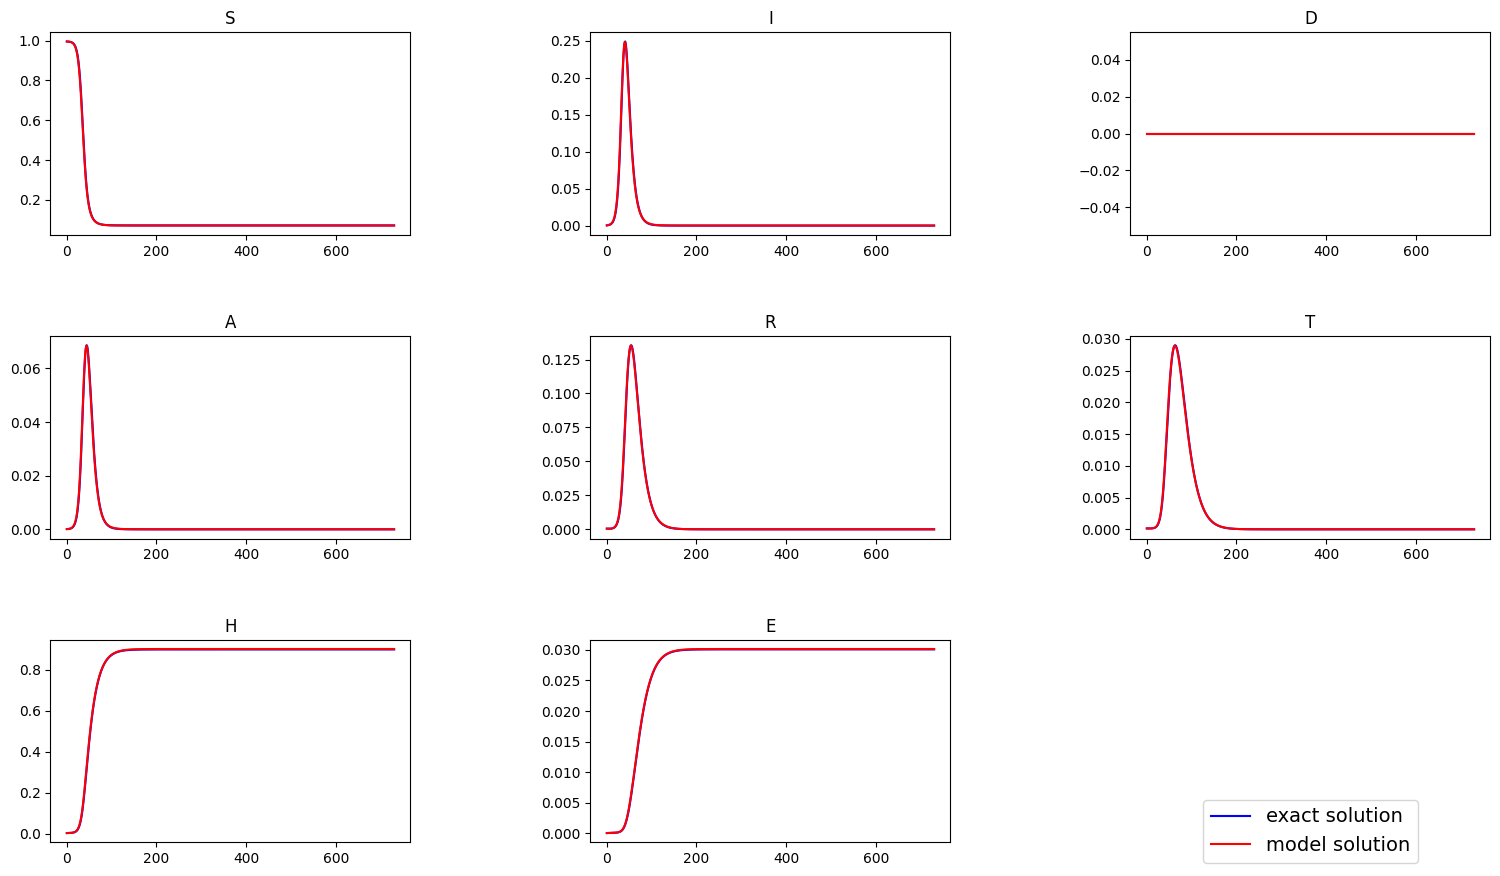

model score:  0.9999829089905944


In [8]:
parameters = Parameters8(alpha=0.3, gamma=0.3)
t, y = sidarthe_simulation8(parameters, t_end=730)

feature_names = ["S", "I", "D", "A", "R", "T", "H", "E"]
functions = [lambda x: x, lambda x, y: x*y]
feature_library = MyLibrary(library_functions=functions, function_names=[
                            lambda x: x, lambda x, y: x+y])

# Set constraints
n_features = 9  # 9 functions in combined feature library
n_targets = y.shape[1]
constraint_rhs = np.zeros(3)  # counted manually

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((constraint_rhs.size, n_targets * n_features))

# add constraints alpha=gamma for first two equations
cons_index = 0
for i in range(0, 2):
    constraint_lhs[cons_index, 5+i*n_features] = 1  # alpha in first equation
    constraint_lhs[cons_index, 7+i*n_features] = -1  # gamma in first equation
    cons_index += 1
    
# alpha1 = alpha2 seems to be to hard to optimize

# add constraint for coefficient for "I" in first equation
constraint_lhs[cons_index, 0+0*n_features] = 1


# MODEL FIT
model = None #reset old model
model = ps.SINDy(
    #differentiation_method=ps.SmoothedFiniteDifference(),
    feature_library=feature_library,
    optimizer=ps.ConstrainedSR3(max_iter=10000, threshold=0.005,
                                normalize=True, initial_guess=None, constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs),
    feature_names=feature_names
)

model.fit(y, t=t, quiet=True)  # suppress warnings
model.print()

# SIMULATION
[s0, i0, d0, a0, r0, t0, h0, e0] = parameters.y0
sim = model.simulate([s0, i0, d0, a0, r0, t0, h0, e0], t=t)

# PLOT
plot_all_compare(t, y, sim, text="")

print("model score: ", model.score(y))

Bei jeder Anpassung des Codes muss man aufpassen, dass die Koeffizientenmatrix nicht zu voll oder zu dünn besetzt ist (over and underfitting).

Idee: Man könnte versuchen gewisse Parameter automatisch anzupassen, um für das Problem geignete Schätzungen zu erhalten. Z.B: starte mit einen hohen threshhold (z.B. 1), sodass die Koeffizientenmatrix sehr dünn besetzt ist. (Das funktioniert nicht immer auf diese Weise. Der Effekt vom threshold hängt auch vom Problem, der Güte der Daten und anderen Parametern im Optimierer ab.)

Falls ein gegebenes Minimum für die Anzahl an geschätzten nichttrivialen Koeffizienten unterschritten ist, halbiere den threshold
Falls ein gegebenes Maximum für die Anzahl an geschätzten nichttrivialen Koeffizienten überschritten ist, wähle einen Zwischenwert?

Diese Linesearch muss nicht konvergieren, da die Anzhal der Koeffizienten vermutlich nicht monoton vom threshold abhängt.

Falls keine Konvergenz nach 100 Schritten, wähle threshold mit bestem Model-Score und/oder mit Anzahl der Koeffizienten am nächsten am gewünschten Intervall.

Für Daten mit Rauschen, können alle Ableitungsmethoden, verschieden Constraints und die Linesearch für den threshold benutzt werden, um ein möglichst gutes Ergebnis zu erhalten. Vorher sollten die Ableitungsmethoden für verrauschte Daten verglichen werden.

---

Hier berechnen wir die Ableitung für mehr Datenpunkte. Wir simulieren das exakte Modell mit kleineren Schritten (ein Zeitschritt pro Stunde statt ein Schritt pro Tag). Es wird am Ende nur eine Ableitung pro Tag ausgegeben, sodass die Größe zum ursprünglichen Problem passen.

In [9]:
def better_derivatives(p: Parameters8, t_0: int = 0, t_end: int = 730, steps_per_day: int = 24, differentiation_method=None):
    """doc"""
    #system needs to be simulated again with more data points
    t, y = sidarthe_simulation8(p, t_end=t_end, steps_per_day=steps_per_day)
    
    if differentiation_method == None:
        #calculate exact derivatives if no differentiation method is given
        x_dot = x_dot_exact_function
    else:
        x_dot = differentiation_method(y, t)
        
    return x_dot[0::steps_per_day]

threshold change too small; break at iteration: 31
The best threshold is: 0.005902958103587064 with  model score: 0.999961188194388
The model-complexity is 25, while the target complexity was 24 +- 5.

S' = -0.012 A + -0.147 SI + -0.147 SA + -0.007 SR
I' = -0.138 I + 0.005 A + 0.148 SI + 0.148 SA + 0.008 SR
D' = 0.000
A' = 0.079 I + -0.266 A + -0.002 SA
R' = 0.200 A + -0.070 R + -0.002 SA
T' = 0.013 A + 0.013 R + -0.063 T
H' = 0.059 I + 0.059 A + 0.056 R + 0.044 T + 0.001 SI + -0.004 SA
E' = 0.019 T

The coefficiants in the following equations show the difference for each parameter compared to the exact solution.
This should not be interpreted as a dynamical system. The format is choosen for better readability.
A negative coefficient means, the calculated value is higher than the exact value.
Remember: Currently the state 'D' is always 0 and values are rounded to 3 decimals places.

S' = '0.012 A + -0.003 SI + -0.008 SD + -0.003 SA + -0.001 SR
I' = '-0.005 A + 0.002 SI + 0.008 SD + 0.0

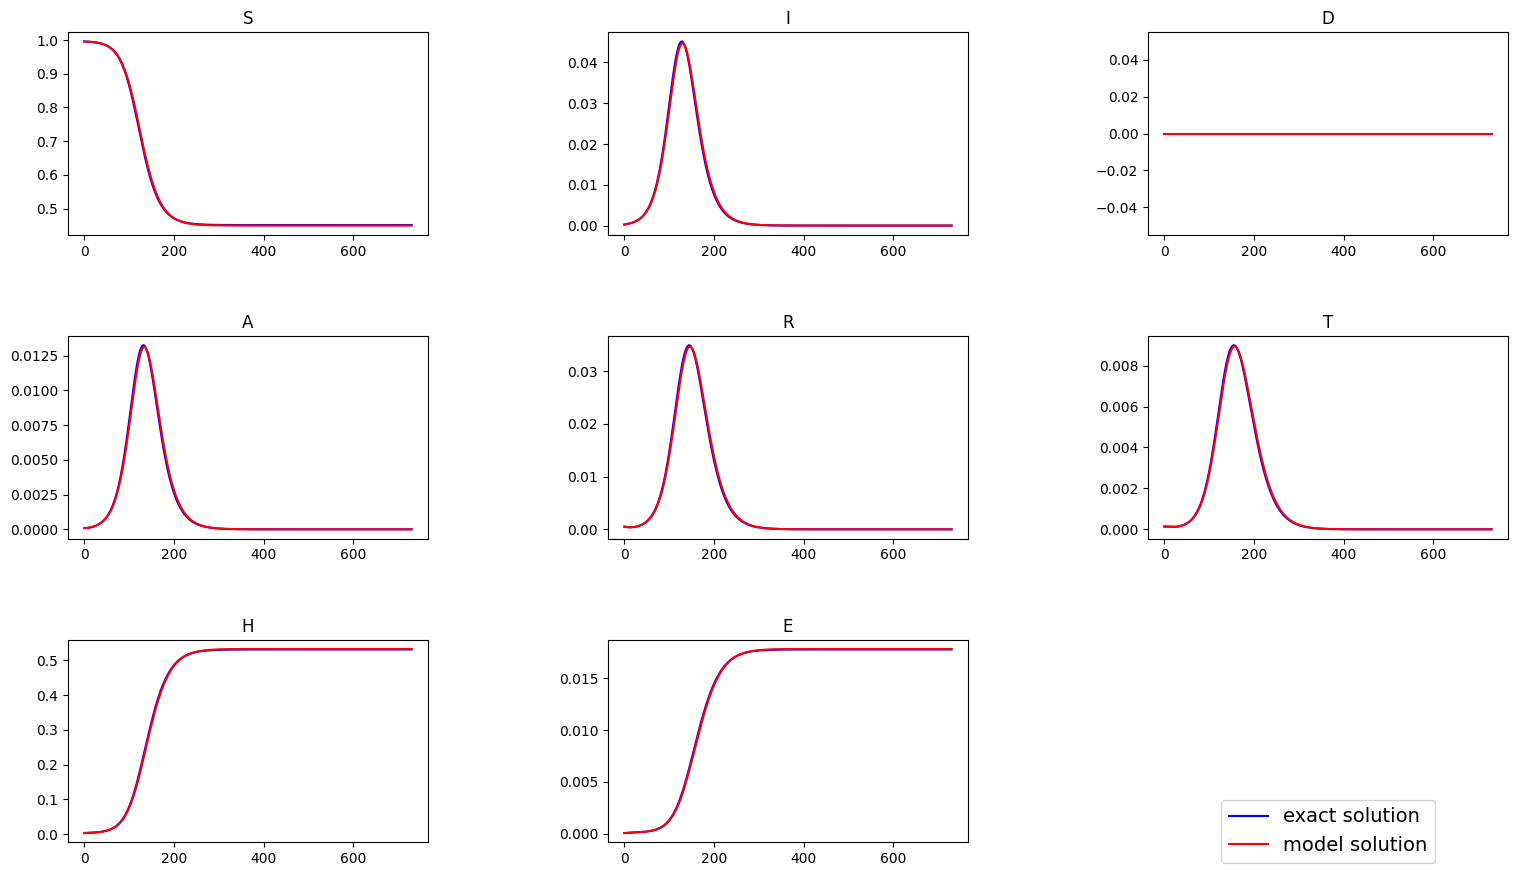

In [10]:
parameters = Parameters8(alpha=0.15, gamma=0.15)
t, y = sidarthe_simulation8(parameters, t_end=730, steps_per_day=1)

initial_guess = None  # set to "None" for no innitial guess

# use precalculated derivatives
# if set to None, SINDy calculates derivatives from data
# set to x_dot_exact_function(parameters, y) for exact derivatives (extremely good results)
# set to better_derivatives(parameters, steps_per_day=24, differentiation_method=ps.FiniteDifference()) for derivatives calculated with more data points
x_dot = None

feature_names = ["S", "I", "D", "A", "R", "T", "H", "E"]
functions = [lambda x: x, lambda x, y: x*y]
feature_library = MyLibrary(library_functions=functions, function_names=[
                            lambda x: x, lambda x, y: x+y])

# Set constraints
n_features = 9  # 9 functions in combined feature library
n_targets = y.shape[1]
constraint_rhs = np.zeros(3)  # counted manually

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((constraint_rhs.size, n_targets * n_features))

# add constraints alpha=gamma for first two equations
cons_index = 0
for i in range(0, 2):
    constraint_lhs[cons_index, 5+i*n_features] = 1  # alpha in first equation
    constraint_lhs[cons_index, 7+i*n_features] = -1  # gamma in first equation
    cons_index += 1

# add constraint for coefficient for "I" in first equation
constraint_lhs[cons_index, 0+0*n_features] = 1

# Loop for threshold optimization
current_thresh = 1
last_good_thresh = current_thresh
min_thresh = 1e-7
target_complexity = 24
complexity_tolerance = 5
best_score = None
best_thresh = current_thresh

iters = 0
while (iters < 200) & (current_thresh > min_thresh):
    # MODEL FIT
    model = None  # reset old model
    model = ps.SINDy(
        differentiation_method=None,
        feature_library=feature_library,
        optimizer=ps.ConstrainedSR3(max_iter=10000, threshold=current_thresh, normalize=True,
                                    initial_guess=initial_guess, constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs),
        # TODO: now change optimizer at two locations
        #optimizer=ps.SR3(max_iter=10000, threshold=current_thresh, normalize=True, initial_guess=initial_guess),
        feature_names=feature_names
    )
    model.fit(y, t=t, quiet=True, x_dot=x_dot)
    complexity_diff = model.complexity-target_complexity

    if complexity_diff <= 0:
        current_thresh *= .8
    elif last_good_thresh-current_thresh > min_thresh:
        current_thresh = (last_good_thresh+current_thresh)/2
    else:
        print("threshold change too small; break at iteration: {}".format(iters))
        break

    if complexity_diff <= complexity_tolerance:
        score = model.score(y)
        if best_score == None:
            best_score = model.score(y)
            best_thresh = current_thresh
        elif score > best_score:
            best_score = model.score(y)
            best_thresh = current_thresh
        last_good_thresh = current_thresh

    iters += 1

if best_score != None:
    print("The best threshold is: {} with  model score: {}".format(
        best_thresh, best_score))

    # SIMULATION
    model = None  # reset old model
    model = ps.SINDy(
        differentiation_method=None,
        feature_library=feature_library,
        optimizer=ps.ConstrainedSR3(max_iter=10000, threshold=current_thresh, normalize=True,
                                    initial_guess=initial_guess, constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs),
        feature_names=feature_names
    )
    model.fit(y, t=t, quiet=True, x_dot=x_dot)

    print("The model-complexity is {}, while the target complexity was {} +- {}.".format(
        model.complexity, target_complexity, complexity_tolerance), end="\n\n")
    model.print()
    print("")
    print("The coefficiants in the following equations show the difference for each parameter compared to the exact solution.")
    print("This should not be interpreted as a dynamical system. The format is choosen for better readability.")
    print("A negative coefficient means, the calculated value is higher than the exact value.")
    print("Remember: Currently the state \'D\' is always 0 and values are rounded to 3 decimals places.", end="\n\n")
    print_model_diff(exact_guess_function(parameters), model)

    [s0, i0, d0, a0, r0, t0, h0, e0] = parameters.y0
    sim = model.simulate([s0, i0, d0, a0, r0, t0, h0, e0], t=t)

    # PLOT
    plot_all_compare(t, y, sim, text="")
else:
    print("No threshold with target_complexity: {} +- {} was found.".format(
        target_complexity, complexity_tolerance))